# Lecture 6:  Model Selection (Cross Validation)
### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine
#### Harvard University <br> Fall 2017 <br> 

---


In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="ticks")
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

C:\Users\charl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# GET THE FULL DATA SET FROM 
#https://drive.google.com/file/d/0B28c493CP9GtRHFVM0U0SVI2Yms/view?usp=sharing
nyc_cab_df = pd.read_csv('data/nyc_car_hire_data.csv', low_memory=False)

FileNotFoundError: File b'data/nyc_car_hire_data.csv' does not exist

In [ ]:
nyc_cab_sample = nyc_cab_df.sample(n=1000, random_state=6)
fares = nyc_cab_sample['Fare_amount'].values
trip_lengths = nyc_cab_sample[['Trip Length (min)']].values


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))


ax.scatter(trip_lengths, fares, color='gray', alpha=0.1, s=20)


ax.set_xlabel('Trip Length (min)')
ax.set_ylabel('Trip Fare ($)')
ax.set_title('NYC Care Hire Data:\n Trip Duration vs Fare Scatter Plot')



In [ ]:
types = nyc_cab_sample[['Type']].values

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

idx_t1 = np.where(types == 1)
idx_t0 = np.where(types == 0)

ax.scatter(trip_lengths[idx_t1], fares[idx_t1[0]], color='gray', alpha=0.1, s=20, label='type 0')
ax.scatter(trip_lengths[idx_t0], fares[idx_t0[0]], color='red', alpha=0.1, s=20, label='type 1')

ax.legend()
ax.set_xlabel('Trip Length (min)')
ax.set_ylabel('Trip Fare ($)')
ax.set_title('NYC Care Hire Data:\n Trip Duration vs Fare Scatter Plot')




In [ ]:
npoints_train=8
X_train = np.random.uniform(low=0, high=1, size=npoints_train).reshape(-1,1)
X_train=np.sort(X_train, axis=0)
y_train = 1.2 + 2.3*X_train + np.random.normal(loc=0, scale=1, size=(npoints_train,1))

npoints_test=8
X_test = np.random.uniform(low=0, high=1, size=npoints_train).reshape(-1,1)
X_test=np.sort(X_test, axis=0)
y_test = 1.2 + 2.3*X_train + np.random.normal(loc=0, scale=1, size=(npoints_test,1))

In [ ]:
gen_poly_terms = PolynomialFeatures(degree=3)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
X_test_with_poly = gen_poly_terms.fit_transform(X_test)

poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_with_poly, y_train)

X_general = np.linspace(0,1, 100).reshape(-1,1)
X_general_with_poly = gen_poly_terms.fit_transform(X_general)
y_general = poly_regression_model.predict(X_general_with_poly)

y_train_hat = poly_regression_model.predict(X_train_with_poly)
y_test_hat = poly_regression_model.predict(X_test_with_poly)


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(X_general, y_general, 'b-' );
ax[0].scatter(X_train, y_train, color='gray', alpha=0.91, s=80)
ax[0].set_ylim((-2,5))

ax[1].plot(X_general, y_general, 'b-' );
ax[1].scatter(X_test, y_test, color='gray', alpha=0.91, s=80)

ax[1].set_ylim((-2,5))

In [251]:

def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Examples of Overfitting

### Too Many Features

In [252]:
train, test = train_test_split(nyc_cab_df, 500)
y_train = train['Fare_amount'].values
y_test = test['Fare_amount'].values

multi_regression_model = LinearRegression(fit_intercept=True)

cols = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

train_R_sq = []
test_R_sq = []
for i in range(1, len(cols) + 1):
    predictors = cols[:i]
    X_train = train[predictors].values
    X_test = test[predictors].values
    
    multi_regression_model.fit(X_train, y_train)
    
    train_R_sq.append(multi_regression_model.score(X_train, y_train))
    test_R_sq.append(multi_regression_model.score(X_test, y_test))

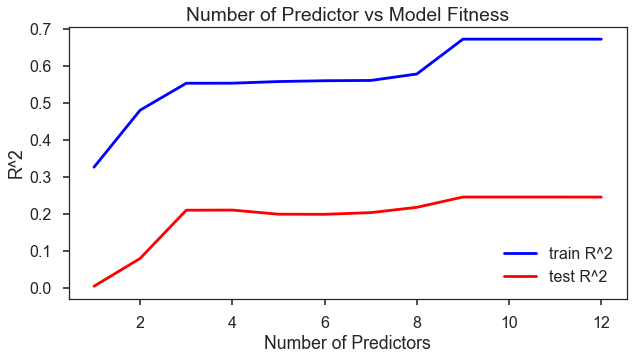

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(1, len(cols) + 1), train_R_sq, color='blue', label='train R^2')
ax.plot(range(1, len(cols) + 1), test_R_sq, color='red', label='test R^2')

ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

### Degree Too High

In [203]:
train, test = train_test_split(nyc_cab_df, 5000)
y_train = train['Fare_amount'].values
y_test = test['Fare_amount'].values

poly_regression_model = LinearRegression(fit_intercept=False, normalize=True)

X_train = train[['Trip Length (min)']].values
X_test = test[['Trip Length (min)']].values



train_R_sq = []
test_R_sq = []
max_deg = 30

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

for d in range(1, max_deg):

    gen_poly_terms = PolynomialFeatures(degree=d)
    X_train_poly = gen_poly_terms.fit_transform(X_train)
    X_test_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model.fit(X_train_poly, y_train)
    
    train_R_sq.append(poly_regression_model.score(X_train_poly, y_train))
    test_R_sq.append(poly_regression_model.score(X_test_poly, y_test))

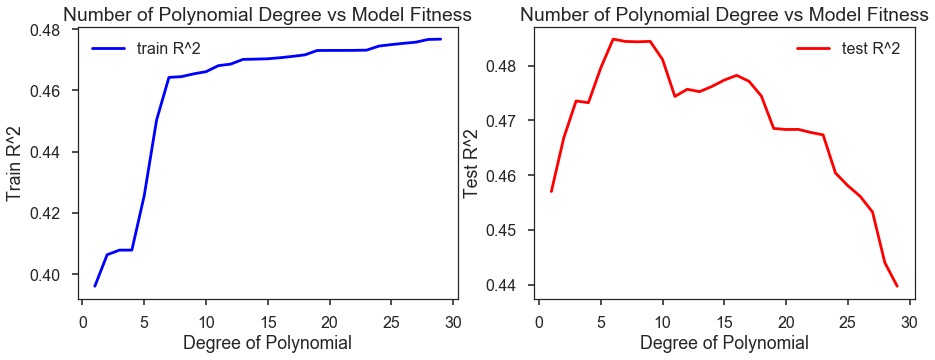

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(1, max_deg), np.array(train_R_sq), color='blue', label='train R^2')

ax[0].set_title('Number of Polynomial Degree vs Model Fitness')
ax[0].set_xlabel('Degree of Polynomial')
ax[0].set_ylabel('Train R^2')
ax[0].legend(loc='best')

ax[1].plot(range(1, max_deg), test_R_sq, color='red', label='test R^2')

ax[1].set_title('Number of Polynomial Degree vs Model Fitness')
ax[1].set_xlabel('Degree of Polynomial')
ax[1].set_ylabel('Test R^2')
ax[1].legend(loc='best')


plt.show()

### Parameters are Too Extreme

In [114]:
X_train = np.linspace(0, 40, 20)
y_train = np.hstack((2 * X_train + 10,  np.array([(2 * 45 + 10) * 10000])))
X_train = np.hstack((X_train, np.array([45])))

regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train.reshape((len(X_train), 1)), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

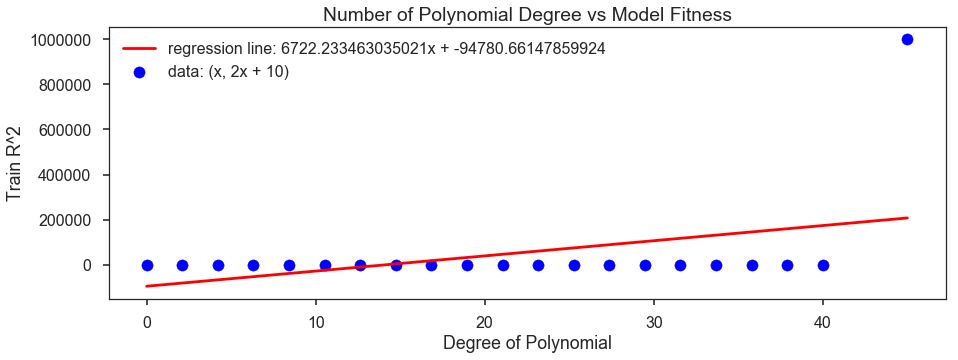

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.scatter(X_train, y_train, color='blue', label='data: (x, 2x + 10)')
ax.plot(X_train, regression_model.intercept_ + regression_model.coef_[0] * X_train, color='red', label='regression line: {}x + {}'.format(regression_model.coef_[0], regression_model.intercept_), )

ax.set_title('Number of Polynomial Degree vs Model Fitness')
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Train R^2')
ax.legend(loc='best')
plt.show()

---

## Stepwise Selection: For Selecting Number of Useful Features in Data

In [266]:
train, validation, test = train_test_split(nyc_cab_df, 5000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

### 1. Forward Selection

In [267]:
all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']
predictors = [([], 0)]

regression_model = LinearRegression(fit_intercept=True)

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors[-1][0]

    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    validation_R_sqs = []


    for predictor in new_predictors:

        k_predictors = best_k_minus_1 + [predictor]
        
        X_train = train[k_predictors].values
        X_val = validation[k_predictors].values
        
        if k == 1:
            X_train = X_train.reshape((len(X_train), 1))
            
        regression_model.fit(X_train, y_train)
        validation_R_sqs.append(regression_model.score(X_val, y_val))
    
    best_k = best_k_minus_1 + [new_predictors[np.argmax(validation_R_sqs)]]
    predictors.append((best_k, np.max(validation_R_sqs)))

X_train = train[all_predictors].values
X_val = validation[all_predictors].values  
regression_model.fit(X_train, y_train)

predictors.append((all_predictors, regression_model.score(X_val, y_val)))

In [268]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  

regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nvalidation R^2: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['Trip_distance', 'Type', 'Trip Length (min)', 'TMIN', 'SNOW', 'SNWD']
validation R^2: 0.7932873297716913
test R^2: 0.7553599215471152


### 2. Backwards Selection

In [269]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))

In [270]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\naic: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['TMIN', 'Trip Length (min)', 'SNOW', 'Pickup_longitude', 'Type', 'Lpep_dropoff_datetime', 'lpep_pickup_datetime', 'Trip_distance', 'SNWD']
aic: 16201.234653155505
test R^2: 0.7546601440805081


---

## Cross Validation: For Selecting Polynomial Model Degree

In [271]:
non_test, test = train_test_split(nyc_cab_df, 5000)
regression_model = LinearRegression(fit_intercept=False)
min_max_scaler = MinMaxScaler()

y_non_test = non_test['Fare_amount'].values
y_test = test['Fare_amount'].values

X_non_test = non_test['Trip Length (min)'].values.reshape((len(non_test), 1))
X_test = test['Trip Length (min)'].values.reshape((len(test), 1))

X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)


kf = KFold(n_splits=10)

x_val_scores = []

for d in range(1, 20):

    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_non_test_poly = gen_poly_terms.fit_transform(X_non_test)

    validation_R_sqs = []
    for train_index, val_index in kf.split(X_non_test_poly):
        X_train, X_val = X_non_test_poly[train_index], X_non_test_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        regression_model.fit(X_train, y_train)
        validation_R_sqs.append(regression_model.score(X_val, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))

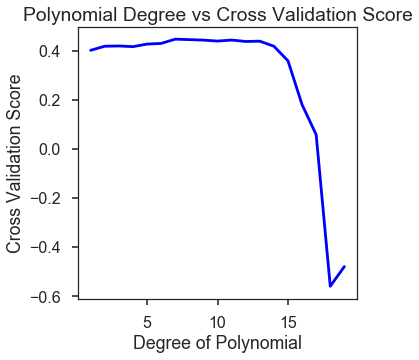

In [272]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 20), x_val_scores, color='blue')

ax.set_title('Polynomial Degree vs Cross Validation Score')
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [273]:
best_degree = range(1, 20)[np.argmax(x_val_scores)]

gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
X_non_test_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_poly = gen_poly_terms.fit_transform(X_test)

regression_model.fit(X_non_test_poly, y_non_test)
test_R_sq = (regression_model.score(X_test_poly, y_test))

print('best degree is:', best_degree)
print('the test R^2 for a degree {} model is: {}'.format(best_degree, test_R_sq))

best degree is: 7
the test R^2 for a degree 7 model is: 0.428438312859164


---

## Cross Validation for kNN 

In [274]:
x_val_scores = []

for k in range(1, 1000, 50):
    out = k * 1. / 1000 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()

    validation_R_sqs = []
    for train_index, val_index in kf.split(X_non_test_poly):
        X_train, X_val = X_non_test_poly[train_index], X_non_test_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(X_train, y_train)
        validation_R_sqs.append(knn_model.score(X_val, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

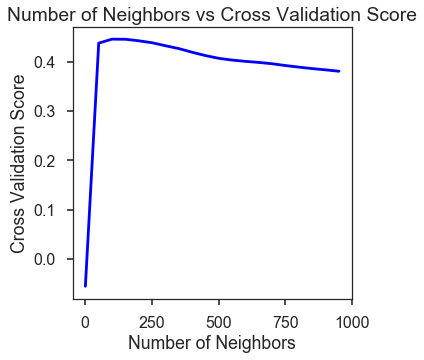

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 1000, 50), x_val_scores, color='blue')

ax.set_title('Number of Neighbors vs Cross Validation Score')
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [59]:
best_k = range(1, 1000, 50)[np.argmax(x_val_scores)]

knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_non_test, y_non_test)
test_R_sq = knn_model.score(X_test, y_test)

print('best k is:', best_k)
print('the test R^2 for a degree {} model is: {}'.format(best_degree, test_R_sq))

best k is: 51
the test R^2 for a degree 14 model is: 0.47720525387665275
